## Imports

In [1]:
# Basic Imports
import random
import datetime
import sys

import pandas            as pd
import numpy             as np
import scipy.stats       as stats

from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.proportion  import proportions_ztest,confint_proportions_2indep,proportions_chisquare

# Data Reading
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

# Custom Modules
sys.path.append('/content/drive/MyDrive/Data Sets/')
import graphs
import plotly_graphs as pg

# Visuals
from warnings        import filterwarnings
from IPython.display import display, HTML

# Set seed for np random
SEED = 42
np.random.seed(SEED)

Mounted at /content/drive/


## Notebook Customization

In [2]:
# Hiding Warnings
filterwarnings('ignore')

# Set seed for np random
np.random.seed(42)

# Making the notebook wider
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib inline

## Table Of Contents





- [Loading Data](#Loading-Data)
- [Part 1 - Exploration](#Exploration)
- [Part 2 - Data Cleaning](#Data-Cleaning)
    - [Updating Data Type](#Updating-Data-Type)
    - [Mapping Values](#Mapping-Values)
    - [Creating A Single Target Variable](#Creating-A-Single-Target-Variable)
- [Part 3 - Visualization](#Visualization)
    - [Reading In Cleaned Data](#Reading-In-Cleaned-Data)
    - [Visual - Experiment](#Experiment)
    - [Visual - Experiment By Response](#Experiment-By-Response)
    - [Visual - Response](#Respone)
    - [Visual - Experiment Date](#Experiment-Date)
    - [Visual - Experiment Hour](#Experiment-Hour)
    - [Visual - Device Make](#Device-Make)
    - [Visual - Operating System](#Operating-System)
    - [Visual - Browser](#Browser)
- [Statistical Testing](#Statistical-Testing)
    - [Hypotheses](#Hypotheses)
    - [Experiment Alpha](#Experiment-Alpha)
    - [General Stats](#General-Stats)
    - [Pretesting](#Pretesting)
    - [χ<sup>2</sup> Test Of Independence](#χ<sup>2</sup>-Test-Of-Independence)
    - [T-test For Means](#T-test-For-Means)
    - [Z-test For Proportions](#Z-test-For-Proportions)
    - [Testing Summary](#Testing-Summary)
- [Part 5 - Conclusions](#Conclusions)

<a id="1"></a>

## Loading Data

In [3]:
# Reading in the data set from Google Drive
ab_df = pd.read_csv('/content/drive/MyDrive/Data Sets/AdSmartABdata.csv')

<a id="2"></a>
## Part 1 - Exploration

In [4]:
# Head 5 rows
ab_df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


Just looking at the dataframe's head, we can immediately see a problem: there are `auction_id` values that did not respond. In addition to the size of the overall dataframe, we need to know how many did not respond.

In [5]:
# Checking the shape of the data

print(f'The shape of the mri set is: {ab_df.shape[0]} rows by {ab_df.shape[1]} columns.')

The shape of the set is: 8077 rows by 9 columns.


In [6]:
response    = ab_df[(ab_df["yes"] == 1) | (ab_df["no"] == 1)]
nonresponse = ab_df[(ab_df["yes"] == 0) & (ab_df["no"] == 0)]

print(f"We have {response.shape[0]} responses and {nonresponse.shape[0]} non-responses.")

We have 1243 responses and 6834 non-responses.


This isn't great: only 1,243 or ~15% of the overall data set actually responded. For the purpose of this A/B testing we will only consider rows that responded.

In [7]:
# Taking the subset that responded
# Adding `.copy()` avoids warnings that we're operating on a subset of the original
ab_sub = ab_df[(ab_df["yes"] == 1) | (ab_df["no"] == 1)].copy()

# Checking size
print(f'The shape of the mri set is: {ab_sub.shape[0]} rows by {ab_sub.shape[1]} columns.')

The shape of the mri set is: 1243 rows by 9 columns.


In [8]:
# Getting the data types

ab_sub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1243 entries, 2 to 8071
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   1243 non-null   object
 1   experiment   1243 non-null   object
 2   date         1243 non-null   object
 3   hour         1243 non-null   int64 
 4   device_make  1243 non-null   object
 5   platform_os  1243 non-null   int64 
 6   browser      1243 non-null   object
 7   yes          1243 non-null   int64 
 8   no           1243 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 97.1+ KB


In [9]:
# Summary of the data types

ab_sub.dtypes.value_counts()

,count
object,5
int64,4


In [10]:
# Checking for null/missing values

ab_sub.isnull().sum()

,0
auction_id,0
experiment,0
date,0
hour,0
device_make,0
platform_os,0
browser,0
yes,0
no,0


In [11]:
# Looking At `experiment` value counts
ab_sub["auction_id"].nunique()

1243

In [12]:
# Looking At `experiment` value counts
ab_sub["experiment"].value_counts()

,count
experiment,
exposed,657
control,586


This works out to ~53% exposed, ~47% control which is close enough to a 50:50 split.

In [13]:
# Looking At `date` value counts
ab_sub["date"].value_counts()

,count
date,
2020-07-03,325
2020-07-09,184
2020-07-08,177
2020-07-04,159
2020-07-10,124
2020-07-05,117
2020-07-07,83
2020-07-06,74


The experiment ran for a total of 8 days. Ideally, we would have 14 days of  but we can't o anything about that.

In [14]:
# Looking At `hour` value counts
ab_sub["hour"].value_counts()

,count
hour,
15,281
8,67
7,59
10,57
9,57
14,51
6,50
5,49
4,46


In [15]:
# Looking At `device_make` value counts
ab_sub["device_make"].value_counts()

,count
device_make,
Generic Smartphone,719
Samsung SM-G960F,45
Samsung SM-G950F,35
Samsung SM-G973F,22
Samsung SM-A202F,18
...,...
VFD 720,1
Samsung SM-J610G,1
VCE-L22,1


There's a long tail of devices, which we'll clean up.

In [16]:
# Looking At `platform_os` value counts
ab_sub["platform_os"].value_counts()

,count
platform_os,
6,1226
5,17


The authors did not provide what OS's `5`, `6`, `7` correspond to.

These values appear to be categories, so we won't change them.

In [17]:
ab_sub.isnull().sum()

,0
auction_id,0
experiment,0
date,0
hour,0
device_make,0
platform_os,0
browser,0
yes,0
no,0


We can condense these values down. to large groups as there are duplicates. We decided to group the single digit browsers into one category called `Others`.

[Section Top](#Exploration)

[Top](#Table-Of-Contents)

<a id="3"></a>
## Data Cleaning

<a id="3a"></a>
### Updating Data Type

In [18]:
# Converting the `date` column to a datetime type
ab_sub["date"] = pd.to_datetime(ab_sub["date"])

<a id="3b"></a>
### Mapping Values

In [19]:
# Defining our dictionaries for mapping

# Dictionaries For Data Mapping
browser_dict = {"Chrome Mobile WebView":"Chrome","Chrome Mobile":"Chrome","Facebook":"Facebook","Samsung Internet":"Samsung Internet",
                "Mobile Safari":"Safari","Chrome":"Chrome","Mobile Safari UI/WKWebView":"Safari","Chrome Mobile iOS":"Chrome"}

# Mapping device type to manufacturer
# We'll rework this later
device_dict  = {"X4_Soul_Infinity_Z":"Other","Pixel 3":"Google","Pixel 4":"Google","Pixel 2":"Google","Pixel 3a":"Google","STF-L09":"Other",
                "DLI-L22":"Other","PCT-L29":"Other","HTC 10":"Other","HTC U12+":"Other","HTC Desire $2":"Other","HTC One $2":"Other",
                "MRD-LX1":"Huawei","ELE-L09":"Huawei","VOG-L09":"Huawei","ANE-LX1":"Huawei","POT-LX1":"Huawei","VOG-L29":"Huawei",
                "ELE-L29":"Huawei","Huawei Browser":"Huawei","LYA-L09":"Huawei","MAR-LX1A":"Huawei","CLT-L09":"Huawei","YAL-L21":"Huawei",
                "SNE-LX1":"Huawei","VTR-L09":"Huawei","PRA-LX1":"Huawei","EVR-N29":"Huawei","EML-L09":"Huawei","FIG-LX1":"Huawei",
                "EVA-L09":"Huawei","VCE-L22":"Huawei","IMO $2":"Other","iPhone":"iPhone","LG-$2":"LG","Moto $2":"Other",
                "Nokia undefined$2$3":"Nokia","Nokia$2$3":"Nokia","TA-1033":"Nokia","Generic Smartphone":"Not Specified",
                "OnePlus ONEPLUS A5000":"Other","A0001":"Other","OnePlus ONEPLUS A5010":"Other","OnePlus ONEPLUS A6013":"Other",
                "OnePlus ONEPLUS A3000":"Other","Samsung SM-A202F":"Samsung","Samsung SM-G935F":"Samsung","Samsung SM-J600FN":"Samsung",
                "Samsung SM-A105FN":"Samsung","Samsung SM-G930F":"Samsung","Samsung SM-G981B":"Samsung","Samsung SM-G973F":"Samsung",
                "Samsung SM-G950F":"Samsung","Samsung SM-G960F":"Samsung","Samsung SM-N960F":"Samsung","Samsung SM-A705FN":"Samsung",
                "Samsung SM-A405FN":"Samsung","Samsung SM-A320FL":"Samsung","Samsung SM-A505FN":"Samsung","Samsung SM-A300FU":"Samsung",
                "Samsung SM-A520F":"Samsung","Samsung SM-A750FN":"Samsung","Samsung SM-J330FN":"Samsung","Samsung SM-J610FN":"Samsung",
                "Samsung SM-G900F":"Samsung","Samsung SM-G955F":"Samsung","Samsung SM-A920F":"Samsung","Samsung SM-J530F":"Samsung",
                "Samsung SM-G975F":"Samsung","Samsung SM-G965F":"Samsung","Samsung SM-G920F":"Samsung","Samsung SM-J415FN":"Samsung",
                "Samsung $2":"Samsung","Samsung SM-G970F":"Samsung","Samsung SM-G986B":"Samsung","Samsung SM-J730F":"Samsung",
                "Samsung SM-G770F":"Samsung","Samsung SM-J330G":"Samsung","Samsung SM-A715F":"Samsung","Samsung SM-J320FN":"Samsung",
                "Samsung SM-J510FN":"Samsung","Samsung SM-N976B":"Samsung","Samsung SM-G980F":"Samsung","Samsung SM-G988B":"Samsung",
                "Samsung SM-G965U1":"Samsung","Samsung SM-A600FN":"Samsung","Samsung SM-N950F":"Samsung","Samsung SM-A310F":"Samsung",
                "Samsung SM-N920I":"Samsung","Samsung SM-G977B":"Samsung","Samsung SM-N970F":"Samsung","Samsung SM-A507FN":"Samsung",
                "Samsung SM-A515F":"Samsung","Samsung SM-G610F":"Samsung","Samsung SM-A530F":"Samsung","Samsung SM-J810F":"Samsung",
                "Samsung SM-G925F":"Samsung","Samsung SM-J500FN":"Samsung","Samsung SM-J330F":"Samsung","Samsung SM-A750GN":"Samsung",
                "Samsung SM-J610G":"Samsung","Samsung SM-N975F":"Samsung","E5823":"Sony","I3312":"Sony","G3311":"Sony","F3311":"Sony",
                "VFD 700":"Other","VFD 820":"Other","VFD 720":"Other","XiaoMi Redmi Note 7":"Other","XiaoMi Redmi 6A":"Other",
                "XiaoMi MI 8 Pro":"Other","XiaoMi MI MAX 3":"Other","XiaoMi MI 6":"Other","XiaoMi Redmi S2":"Other"}

In [20]:
# Mapping values for the `experiment`, `browser`, `device_make`

ab_sub["browser"]     = ab_sub["browser"].map(browser_dict, na_action="ignore")
ab_sub["device_make"] = ab_sub["device_make"].map(device_dict, na_action="ignore")

In [21]:
ab_sub.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,Sony,6,Chrome,0,1
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Not Specified,6,Chrome,1,0
20,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,Not Specified,6,Chrome,0,1
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung,6,Facebook,1,0
27,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,Not Specified,6,Chrome,0,1


<a id="3c"></a>
### Creating A Single Target Variable

In [22]:
ab_sub[(ab_sub["yes"] == 1) & (ab_sub["no"] == 1)]

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no


We can see that there aren't any erroneous rows that have `1` for both `yes` and `no`. Because of that, we feel comfortable just doing a simple `lambda` to define a response value.

In [23]:
ab_sub["response"] = ab_sub["yes"].apply(lambda x: "Yes" if x == 1 else "No")

In [24]:
# Checking our results
ab_sub["response"].value_counts()

,count
response,
No,671
Yes,572


In [25]:
ab_sub["yes"].value_counts()

,count
yes,
0,671
1,572


We can see that the `response` counts mirror the `yes` counts, so our change worked. Next we will drop `yes` and `no` and save our results to a new dataframe and .csv file.

In [26]:
# Saving to a new .csv and resetting the index
ab_sub.to_csv("/content/drive/MyDrive/Data Sets/ab_response_data.csv",index=False)

[Section Top](#Exploration)

[Top](#Table-Of-Contents)

<a id="4"></a>
## Visualization

<a id="4a"></a>
### Reading In Cleaned Data

In [27]:
ab = pd.read_csv("/content/drive/MyDrive/Data Sets/ab_response_data.csv")

In [28]:
# Checking the layout
ab.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no,response
0,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,Sony,6,Chrome,0,1,No
1,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Not Specified,6,Chrome,1,0,Yes
2,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,Not Specified,6,Chrome,0,1,No
3,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung,6,Facebook,1,0,Yes
4,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,Not Specified,6,Chrome,0,1,No


In [29]:
ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1243 entries, 0 to 1242
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   1243 non-null   object
 1   experiment   1243 non-null   object
 2   date         1243 non-null   object
 3   hour         1243 non-null   int64 
 4   device_make  1243 non-null   object
 5   platform_os  1243 non-null   int64 
 6   browser      1243 non-null   object
 7   yes          1243 non-null   int64 
 8   no           1243 non-null   int64 
 9   response     1243 non-null   object
dtypes: int64(4), object(6)
memory usage: 97.2+ KB


In [30]:
# The date column reverted to an object, so we'll force to datetime again
ab["date"] = pd.to_datetime(ab["date"])

<a id="4b"></a>
### Experiment

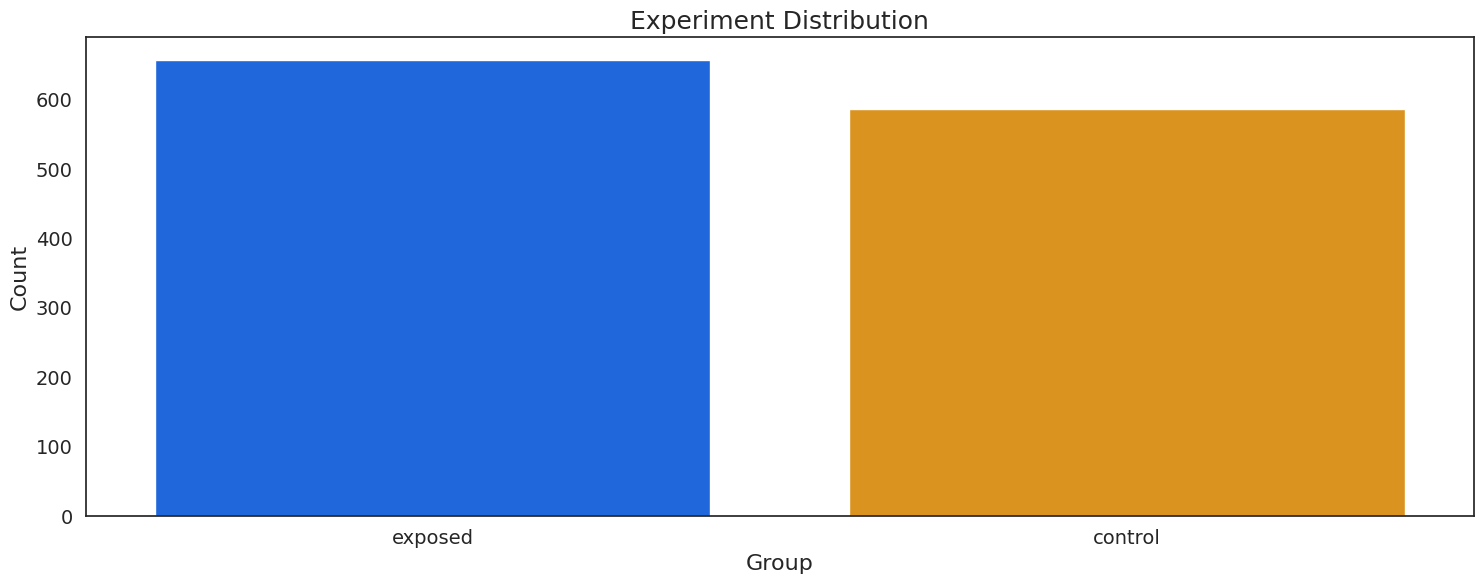

In [31]:
graphs.countplots(df      = ab,
                  columns = ["experiment"],
                  titles  = ["Experiment Distribution"],
                  labels  = ["Group"],
                  ylabel  = "Count",
                  dim     = (15,6),
                  palette = ["#0060FA","#FA9A00"],
                  row     = 1,
                  col     = 1)

Our groups aren't exactly equal, but it's close enough. The difference in sizing is likely due to the effect of subsetting the dataframe earlier.

<a id="4c"></a>
### Experiment By Response

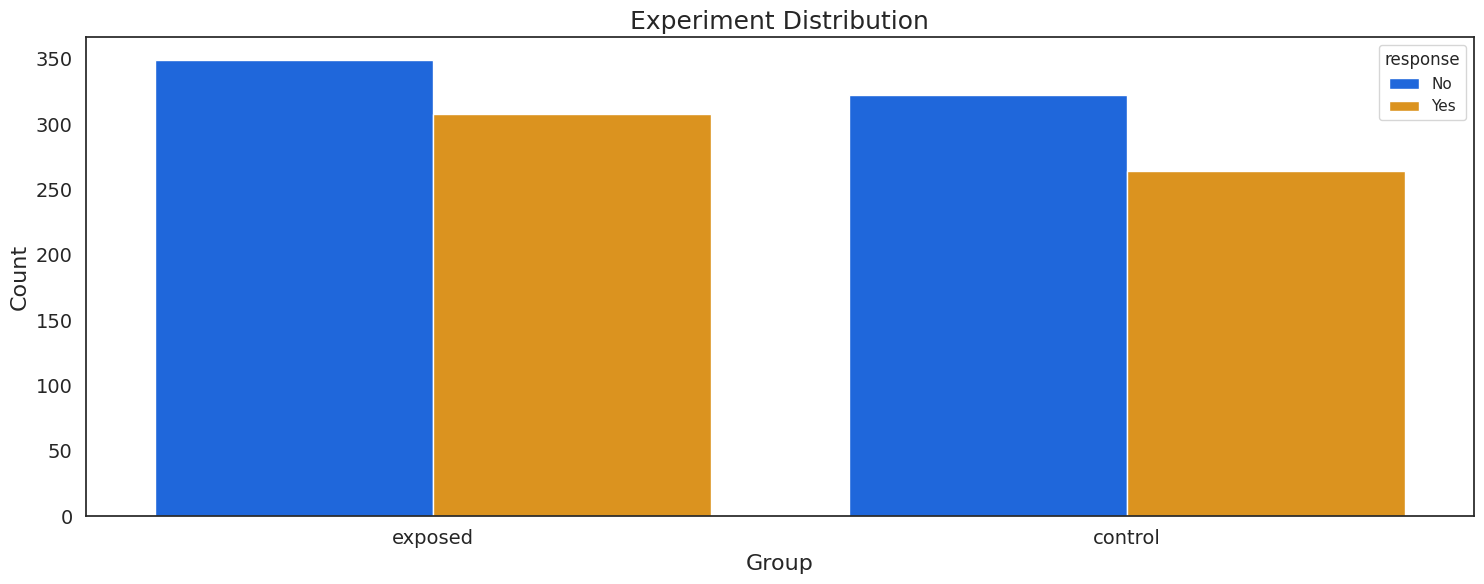

In [32]:
graphs.countplots(df      = ab,
                  columns = ["experiment"],
                  titles  = ["Experiment Distribution"],
                  labels  = ["Group"],
                  ylabel  = "Count",
                  dim     = (15,6),
                  hue     = "response",
                  palette = ["#0060FA","#FA9A00"],
                  row     = 1,
                  col     = 1)

The ratio response/no response ratio between the two groups seems similar at a cursory glance.

[Section Top](#Visualization)

[Top](#Table-Of-Contents)

<a id="4d"></a>
### Response

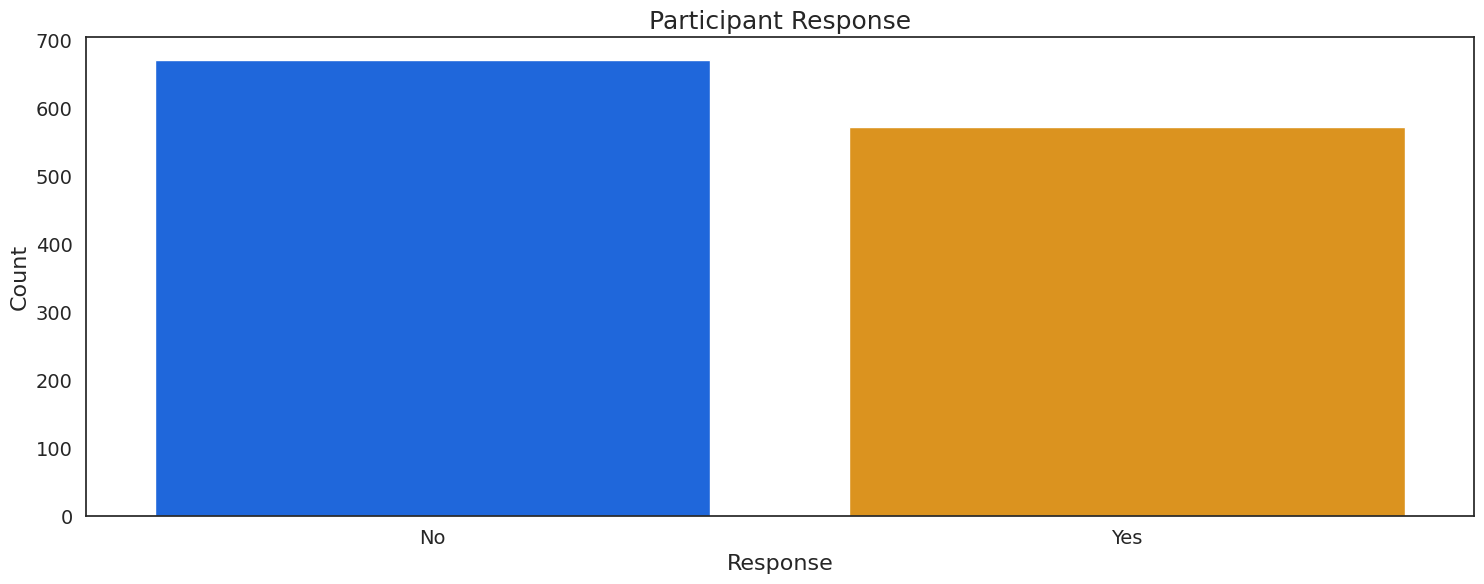

In [33]:
graphs.countplots(df      = ab,
                  columns = ["response"],
                  titles  = ["Participant Response"],
                  labels  = ["Response"],
                  ylabel  = "Count",
                  palette = ["#0060FA","#FA9A00"],
                  dim     = (15,6),
                  row     = 1,
                  col     = 1)

<a id="4e"></a>
### Experiment Date

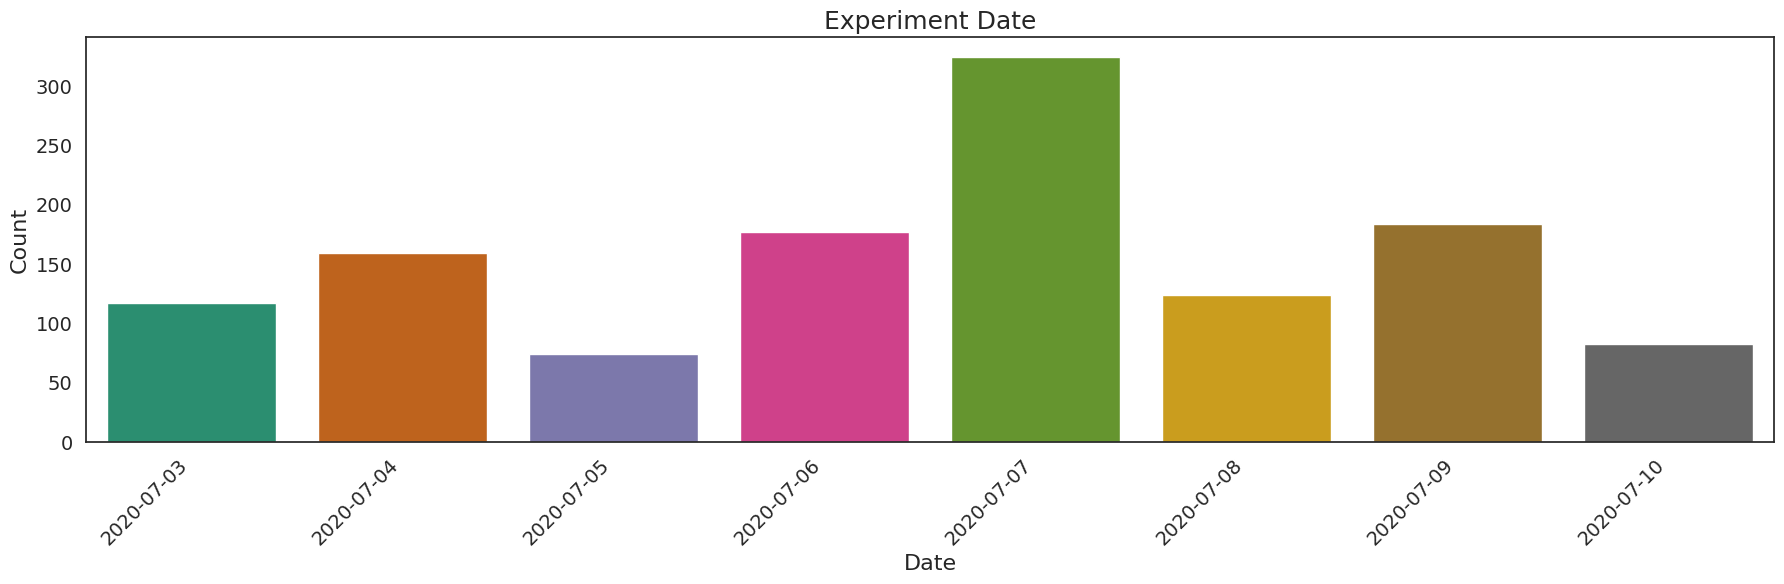

In [34]:
graphs.countplots_dt(df      = ab,
                     columns = ["date"],
                     titles  = ["Experiment Date"],
                     labels  = ["Date"],
                     ylabel  = "Count",
                     palette = "Dark2",
                     dim     = (18,6),
                     row     = 1,
                     col     = 1)

We check a calendar for July 2020:

| Month | Day | Day Of Week |
|:-----:|:---:|:------------|
| July  | 3   | Friday      |
| July  | 4   | Saturday    |
| July  | 5   | Sunday      |
| July  | 6   | Monday      |
| July  | 7   | Tuesday     |
| July  | 8   | Wednesday   |
| July  | 9   | Thursday    |
| July  | 10  | Friday      |

One of the problems with having an experiment that ran for <2 weeks is that we cannot be sure if we can take into account changes in traffic caused by weekend vs weekday browsing. Additionally, we are working on a subset of the overall data set which could be introducing other biases.

[Section Top](#Visualization)

[Top](#Table-Of-Contents)

<a id="4f"></a>
### Experiment Hour

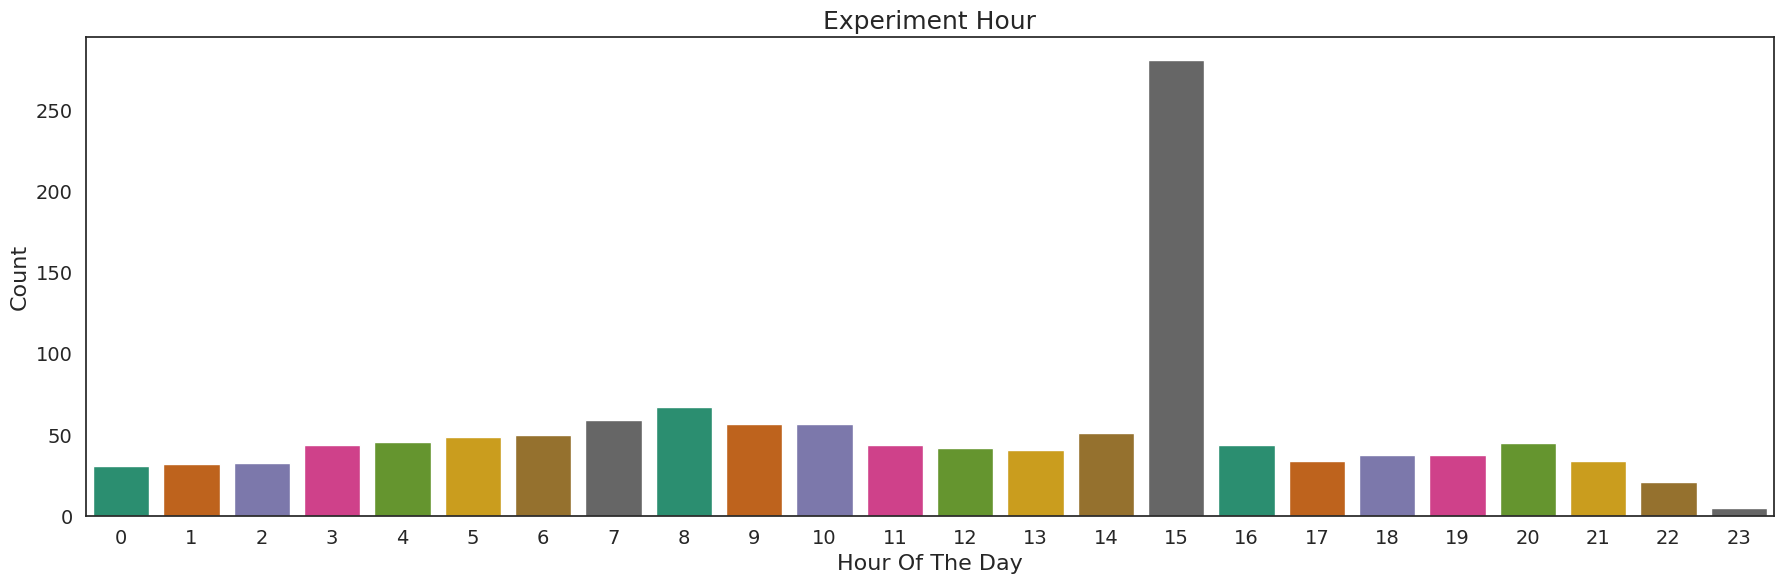

In [35]:
graphs.countplots(df      = ab,
                  columns = ["hour"],
                  titles  = ["Experiment Hour"],
                  labels  = ["Hour Of The Day"],
                  ylabel  = "Count",
                  palette = "Dark2",
                  dim     = (18,6),
                  row     = 1,
                  col     = 1)

We don't have the full picture of the data, but the spike in IDs during 15:00 is interesting to us: we expected to see a peak in the afternoon, but that may be due to not having the full data set.

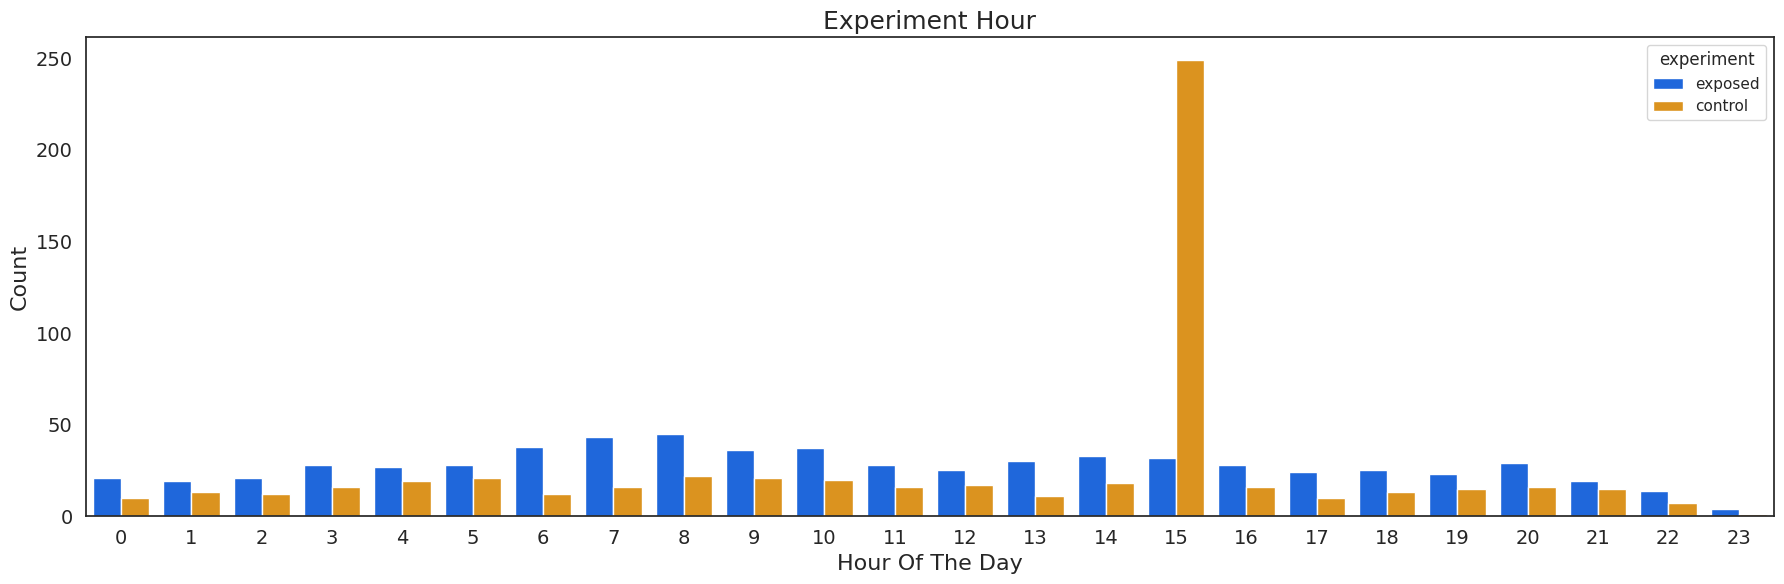

In [36]:
graphs.countplots(df      = ab,
                  columns = ["hour"],
                  titles  = ["Experiment Hour"],
                  labels  = ["Hour Of The Day"],
                  ylabel  = "Count",
                  palette = ["#0060FA","#FA9A00"],
                  hue     = "experiment",
                  dim     = (18,6),
                  row     = 1,
                  col     = 1)

Drilling down further, we can see that the anomaly at 15:00 is only in the control group.

[Section Top](#Visualization)

<a id="4g"></a>
### Device Make

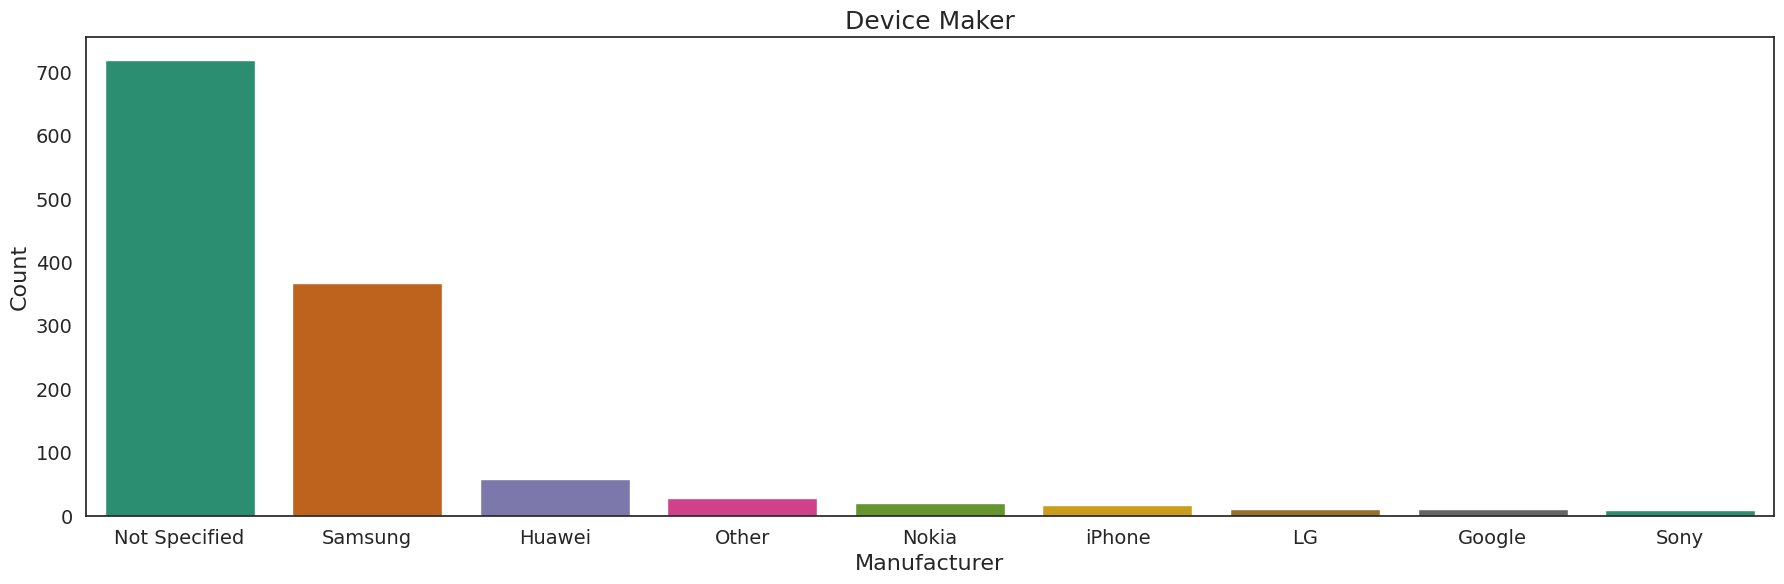

In [37]:
graphs.countplots_order(df      = ab,
                        columns = ["device_make"],
                        titles  = ["Device Maker"],
                        labels  = ["Manufacturer"],
                        ylabel  = "Count",
                        palette = "Dark2",
                        dim     = (18,6),
                        row     = 1,
                        col     = 1)

This isn't the most helpful column as the majority of the maker is non-specified. If we were modeling rather than A/B testing, we would consider dropping the column.

<a id="4h"></a>
### Operating System

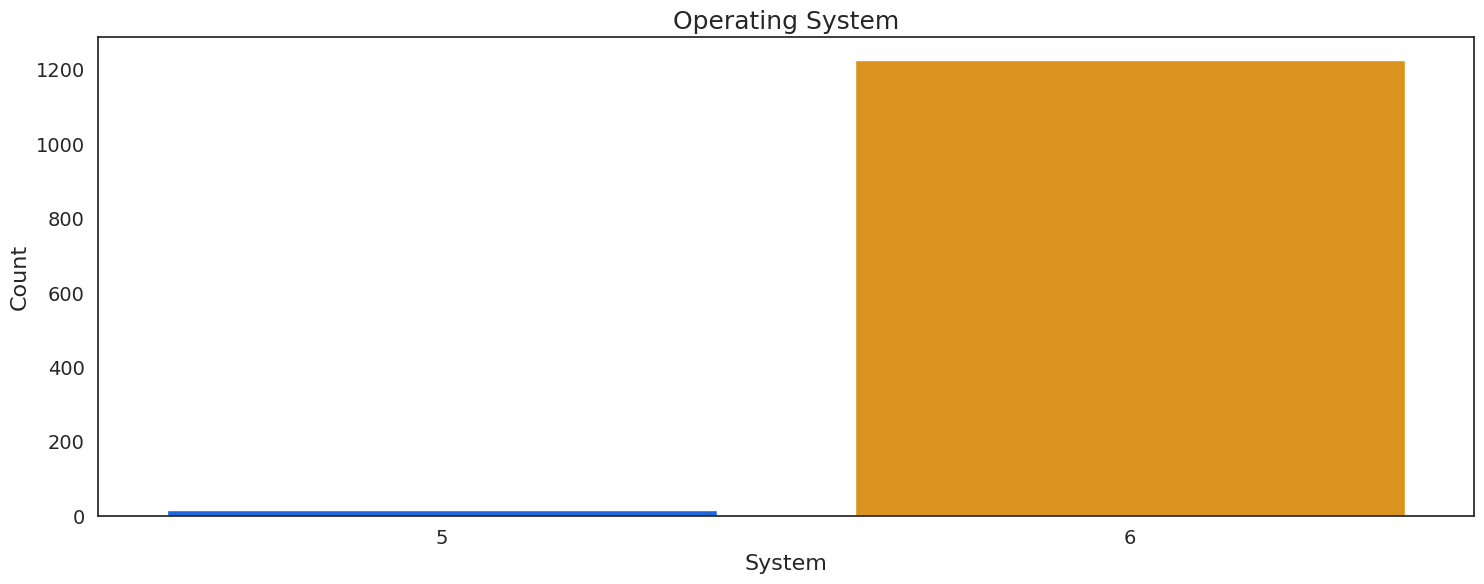

In [38]:
graphs.countplots(df      = ab,
                  columns = ["platform_os"],
                  titles  = ["Operating System"],
                  labels  = ["System"],
                  ylabel  = "Count",
                  palette = ["#0060FA","#FA9A00"],
                  dim     = (15,6),
                  row     = 1,
                  col     = 1)

The author does not provide information what operating systems are encoded by `5` and `6`, though if we had to guess we would say that `6` might be Android.

<a id="4i"></a>
### Browser

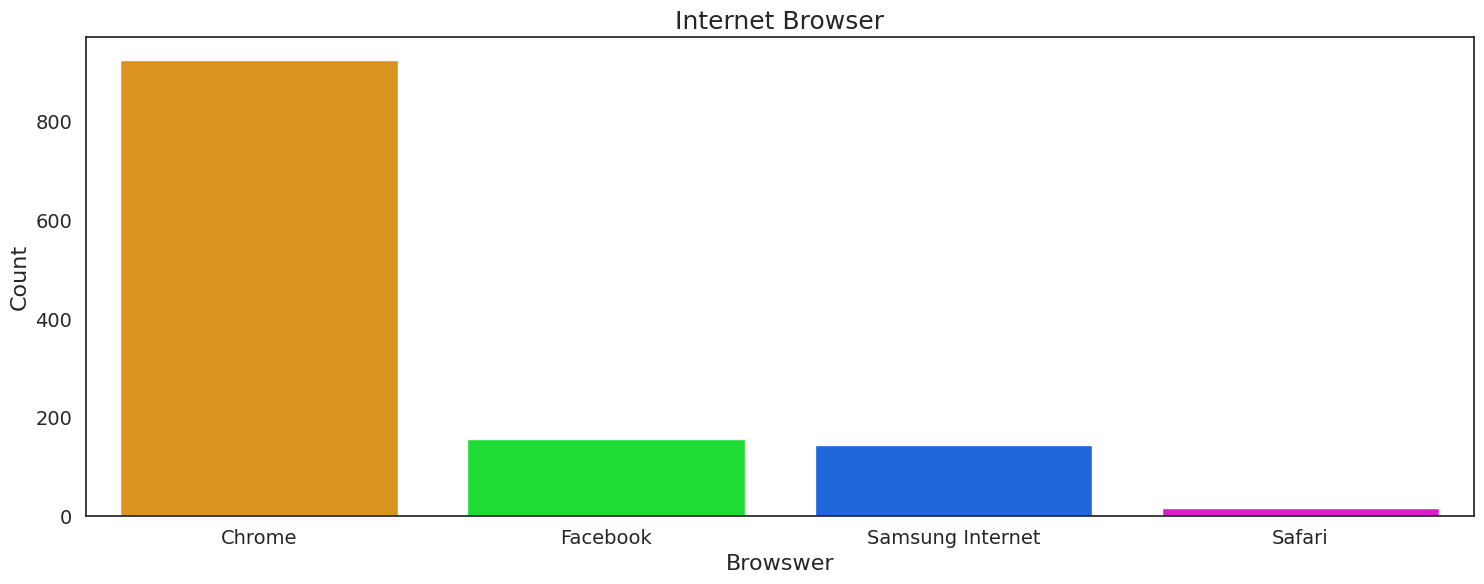

In [39]:
# Address nulls
graphs.countplots(df      = ab,
                  columns = ["browser"],
                  titles  = ["Internet Browser"],
                  labels  = ["Browswer"],
                  ylabel  = "Count",
                  palette = ["#FA9A00","#00FA1D","#0060FA","#FA00DD"],
                  dim     = (15,6),
                  row     = 1,
                  col     = 1)

 No surprises here, Chrome is the most popular mobile browser worldwide; though we were expecting to see more Safari. Again, this is a susbet of the data so overall trends may be different.

[Section Top](#Visualization)

[Top](#Table-Of-Contents)

<a id="5"></a>
## Statistical Testing

<a id="5a"></a>
### Hypotheses


Our hypotheses are the following:

- H<sub>0</sub>: the experiment did not produce an increase in questionnaire response

- H<sub>A</sub>: the experiment did produced an increase in questionnaire response



---



ur testing will consist of two portions:

1. A/A Testing: this will let us know if our data is valid for the purpose of testing.

2. A/B Testing: this will let us know if our experimentation worked and is composed of 3 tests:

    - χ<sup>2</sup> test for independence: to test if the data comes from the same distribution, i.e. if the data is independent.

    - T-test for means: to test if the two groups have different means.

    - Z-test for proportions: to test if the two groups came from different populations of proportion.

3. Conclusions: at the end we will evaluate all results and determine if the experiment worked or not.

<a id="5b"></a>
### Experiment Alpha

For this experiment we will be using a p_value of 0.05, which is standard.

In [40]:
# Experiment parameters
alpha = 0.05

<a id="5c"></a>
### General Stats

In [41]:
# Get the subset tables of control and treatment results
control_pop = ab[ab["experiment"] == "control"]
exposed_pop = ab[ab["experiment"] == "exposed"]

# Get general stats
# Control and treatment counts and rates
# Control and treatment samples
control_count = control_pop["yes"].sum()          # Control Sign-Up Count
exposed_count = exposed_pop["yes"].sum()      # Treatment Sign-Up Count
control_size  = control_pop["auction_id"].count()       # Control Sample Size
exposed_size  = exposed_pop["auction_id"].count()   # Treatment Sample Size

print(f"Control Sign Up : {control_count}")
print(f"Exposed Sign Up : {exposed_count}")
print(f"Control Size    : {control_size}")
print(f"Exposed Size    : {exposed_size}")


Control Sign Up : 264
Exposed Sign Up : 308
Control Size    : 586
Exposed Size    : 657


In [42]:
# Computing our CI for the T- and Z-tests we will run
# Also getting our lower and upper bounds
ci = confint_proportions_2indep(exposed_count,
                                exposed_size,
                                control_count,
                                control_size,
                                method     = None,
                                compare    = 'diff',
                                alpha      = alpha,
                                correction = True)
lower_bound = ci[0]
upper_bound = ci[1]

<a id="5d"></a>
### Pre-Testing

Before proceeding with the A/B testing, we opted to perform an A/A test: an A/A test is run to ensure that our two groups are *not* the same. Typically organizations will run A/A testing to ensure that their infrastructure is set up correctly and that the data collection is working as expecting. Since we are not working with any infrastructure for this project, we will A/A test to ensure that our data is in fact not the same.

As with A/B testing, we have two hypotheses:

- H<sub>0</sub>: The two groups are the same
- H<sub>A</sub>: The two groups are not the same

In [43]:
pre_chi, pre_p, tab = proportions_chisquare([control_count, exposed_count], nobs=[control_size, exposed_size])

print(f'---------- A/A Testing Before A/B Testing ----------')
print(f'The A/A chi2 value : {pre_chi}')
print(f'The A/A p_value    : {pre_p}')

  # Printing our conclusion
print("Conclusion: \n")
if pre_p < alpha:
  print('Reject the Null: conclude that there is statistical significance in the difference between the two groups.')
else:
  print('Fail to reject the Null hypothesis: proceed with the AB test.')

---------- A/A Testing Before A/B Testing ----------
The A/A chi2 value : 0.41690289642162887
The A/A p_value    : 0.518486498219898
Conclusion: 

Fail to reject the Null hypothesis: proceed with the AB test.


[Section Top](#Statistical-Testing)

[Top](#Table-Of-Contents)

<a id="5e"></a>
###χ<sup>2</sup> Test Of Independence

Our hypotheses:


*   H<sub>0</sub>: The two groups are independent
*   H<sub>A</sub>: The two groups are not independent








In [44]:
# Defining sets for our contingency table
test_c_yes = ab[(ab["experiment"] == "control") & (ab["response"] == "Yes")]
test_c_no  = ab[(ab["experiment"] == "control") & (ab["response"] == "No")]
test_e_yes = ab[(ab["experiment"] == "exposed") & (ab["response"] == "Yes")]
test_e_no  = ab[(ab["experiment"] == "exposed") & (ab["response"] == "No")]

print(f"Positive Control Responses: {test_c_yes.shape[0]}")
print(f"Negative Control Responses: {test_c_no.shape[0]}")
print(f"Positive Exposed Responses: {test_e_yes.shape[0]}")
print(f"Negative Exposed Responses: {test_e_no.shape[0]}")

Positive Control Responses: 264
Negative Control Responses: 322
Positive Exposed Responses: 308
Negative Exposed Responses: 349


In [45]:
# Grouping our dataset to get counts of `yes` and `no`
ab_group = ab.groupby("experiment")[["yes","no"]].sum()

# Calculating the chi2 of independence
chi2, p_value, dof, expected = stats.chi2_contingency(ab_group)

# Saving our chi2 p_value
chi_p = p_value

# Printing our chi2, the degrees of freedom, and the p_value
print(f"The chi2 value is: {chi2}.")
print(f"There is/are {dof} degree(s) of freedom")
print(f"The p-value is {p_value} \n")

# Printing our conclusion
print("Conclusion: \n")
if p_value < alpha:
  print('Reject the Null and conclude that there is statistical significance in the difference of response rates.')
else:
  print('Fail to reject the Null.')

The chi2 value is: 0.3465426444731172.
There is/are 1 degree(s) of freedom
The p-value is 0.5560768104229136 

Conclusion: 

Fail to reject the Null.


<a id="5f"></a>
### T-test For Means

Our hypotheses:


*   H<sub>0</sub>: The mean of the two groups is exactly 0
*   H<sub>A</sub>: The mean of the two groups is not 0

In [46]:
# Defining our control and exposed yes responses
c_yes = ab[ab["experiment"] == "control"]["yes"]
e_yes = ab[ab["experiment"] == "exposed"]["yes"]

# Conducting the T-test
tstat, p_value, ab_df = ttest_ind(e_yes, c_yes)

# Saving our T-test p_value
ttest_p = p_value

# Printing our T-stat and the p_value
print(f"The T-stat value is: {tstat}.")
print(f"The p-value is {p_value}")

# Printing our conclusion
print("Conclusion: \n")
if p_value < alpha:
  print('Reject the Null and conclude that there is statistical significance in the difference of response rates.')
else:
  print('Fail to reject the Null.')

The T-stat value is: 0.6452687398426953.
The p-value is 0.5188723218522058
Conclusion: 

Fail to reject the Null.


<a id="5g"></a>
### Z-test For Proportions

Our hypotheses:


*   H<sub>0</sub>: The mean of the two groups is exactly 0
*   H<sub>A</sub>: The mean of the two groups is not 0

In [47]:
# Subsetting our dataset into control/exposed
c_ab = ab[ab["experiment"] == "control"]
e_ab = ab[ab['experiment'] == "exposed"]

# Counting responses for each
c_yes   = c_ab["yes"].sum()
e_yes   = e_ab["yes"].sum()

# Counting total rows for each
c_total = c_ab.shape[0]
e_total = e_ab.shape[0]

# Running the Z test
zstat, p_value = proportions_ztest([c_yes, e_yes], [c_total, e_total])

# Saving our T-test p_value
ztest_p = p_value

# Printing our Z-stat and the p_value
print(f"The T-stat value is: {zstat}.")
print(f"The p-value is {p_value}")

# Printing our conclusion
print("Conclusion: \n")
if p_value < alpha:
  print('Reject the Null and conclude that there is statistical significance in the difference of response rates.')
else:
  print('Fail to reject The Null.')

The T-stat value is: -0.645680181221037.
The p-value is 0.5184864982198968
Conclusion: 

Fail to reject The Null.


<a id="5h"></a>
### Testing Summary

In [48]:
print('-----------Sample Sizes-------------------')
print(f'Control        : {control_size}')
print(f'Treatment      : {exposed_size} \n')

print('-----------Experiment Alpha----------------')
print(f'Alpha          : {alpha} \n')

print('-----------Chi Squared Stats --------------')
print(f'Test Statistic : {chi2:3f}')
print(f'P-Value        : {chi_p:.5f} \n')

print('-----------T-Test Stats ------------------')
print(f'Test Statistic : {tstat:3f}')
print(f'P-Value:       : {ttest_p:.5f} \n')

print('-----------Z-Test Stats ------------------')
print(f'Test Statistic : {zstat:3f}')
print(f'P-Value        : {ztest_p:.5f} \n')

print('-----------Confidence Intervals ----------')
print(f'Absolute Difference CI: {lower_bound:.3f} to {upper_bound:.3f}')

-----------Sample Sizes-------------------
Control        : 586
Treatment      : 657 

-----------Experiment Alpha----------------
Alpha          : 0.05 

-----------Chi Squared Stats --------------
Test Statistic : 0.346543
P-Value        : 0.55608 

-----------T-Test Stats ------------------
Test Statistic : 0.645269
P-Value:       : 0.51887 

-----------Z-Test Stats ------------------
Test Statistic : -0.645680
P-Value        : 0.51849 

-----------Confidence Intervals ----------
Absolute Difference CI: -0.037 to 0.073


[Section Top](#Visualization)

[Top](#Table-Of-Contents)

<a id="6"></a>
## Conclusions

We have failed to reject our null hypothesis:

- Our measured p-values are greater than our agreed upon alpha.

- Our confidence interval contains 0, which means our p value is greater than alpha.

[Top](#Table-Of-Contents)